# <a id='toc1_'></a>[__Классификация методом k ближайших соседей. Наивный байесовский классификатор__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Классификация методом k ближайших соседей. Наивный байесовский классификатор__](#toc1_)    
  - [__Импорты и настройки__](#toc1_1_)    
  - [__Метрики__](#toc1_2_)    
  - [__Классификация методом kNN__](#toc1_3_)    
  - [__Взвешенный kNN__](#toc1_4_)    
  - [__Алгоритмы и эмпирический риск__](#toc1_5_)    
  - [__k-блочная кросс-валидация (k-fold cross-validation)__](#toc1_6_)    
  - [__Наивный байесовский классификатор__](#toc1_7_)    
  - [__Классификация писем. Сглаживание по Лапласу__](#toc1_8_)    
  - [__Решение задач ВШЭ__](#toc1_9_)    
    - [__Задание 1__](#toc1_9_1_)    
    - [__Задание 2__](#toc1_9_2_)    
    - [__Задание 3__](#toc1_9_3_)    
    - [__Задание 4__](#toc1_9_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# стандартная библиотека
from collections import Counter, namedtuple

In [2]:
# сторонние библиотеки
from keras.datasets import mnist
from scipy.stats import uniform
from scipy.spatial.distance import cdist
from scipy.special import softmax
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    GridSearchCV, KFold, train_test_split
)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
import pandas as pd
import seaborn as sns

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

***
## <a id='toc1_2_'></a>[__Метрики__](#toc0_)

Пусть $X$ – какое-то множество. __Метрикой__ (расстоянием) на множестве $X$ называют функцию $d(x,y): X \times X \to \R$, которая для любых $x,y,z \in X$ удовлетворяет трем свойствам:
1. Она неотрицательна, то есть $d(x,y) \geqslant 0$, причем $d(x,y) = 0 \iff x = y$;
2. Она симметрична, то есть $d(x,y) = d(y,x)$;
3. Выполняется неравенство треугольника, то есть $d(x,y) \leqslant d(x,z) + d(z,y)$.

Расстояние Минковского:

$$d_q(x,x') = \sqrt[q]{\sum_{i=1}^p|x_i - x'_i|^q}, \; p \geqslant 1$$

$q = 1: \quad$ манхэттенское расстояние (расстояние городских кварталов, _cityblock_);

$q = 2: \quad$ евклидово расстояние;

$q \to +\infty: \quad$ расстояние Чебышёва, 
$$d_{\infty}(x,x') = \max_{i \in \{1, \dots ,p\}} |x_i - x'_i|.$$

[__scipy.spatial.distance__](https://scipy.github.io/devdocs/reference/spatial.distance.html#distance-computations-scipy-spatial-distance)

***
## <a id='toc1_3_'></a>[__Классификация методом kNN__](#toc0_)

Алгоритм:
1. Вычисляем расстояние от тестового объекта до каждого элемента тренировочного набора данных. 
2. Упорядочиваем эти расстояния по неубыванию и перенумеровываем элементы тренировочного набора данных (первый элемент – самый близкий к тестовому объекту, второй – второй по близости и т.д.). 
3. Перенумеровываем отклики согласно перенумерованным объектам.
4. Ищем тот класс (или те классы), объекты которых встретились среди $k$ ближайших элементов чаще всего.

Описанный алгоритм классификации исходит из __гипотезы компактности__: возможные классы образуют компактно локализованные подмножества в пространстве объектов.

In [4]:
tested = np.zeros((1,2))
colors = 'purple', 'orange'
t = 50  # base parameter
ticks = np.linspace(-t, t, int(t / 5) + 1)
fields = 'class_', 'Minkowski_p_norm', 'k', 'nvotes', 'percentage'
knnResult = namedtuple('knnResult', fields)

In [5]:
data = uniform.rvs(-t, 2*t, size=(4*t, 3))
X, y = data[:,:2], data[:,2]
y = np.where(y > 0, *colors)
aes_voting = {'s': 80, 'alpha': 0.5}
aes_watching = {'s': 40, 'alpha': 0.7}

In [6]:
def knnBinClf(*, k: int, pnorms: list | tuple) -> None:
    """
    Бинарный knn-классификатор для заданных p-норм метрики Минковского.
    """
    pn = len(pnorms)
    axs = plt.subplots(ncols=pn, figsize=(7*pn, 7))[1]
    it = iter(axs if pn > 1 else [axs])
    for p in pnorms:
        ix = np.argsort(cdist(X, tested, 'minkowski', p=p).squeeze())
        voting, watching = ix[:k], ix[k:]
        class_, nvotes = Counter(y[voting]).most_common(1)[0]
        perc = round(100 * nvotes / k, 1)
        print(knnResult(class_, p, k, nvotes, perc))
        ax = next(it)
        ax.scatter(*X[voting].T, c=y[voting], **aes_voting)
        ax.scatter(*X[watching].T, c='k', **aes_watching)
        ax.scatter(*tested[0], c='r', **aes_voting)
        ax.set_xlim(-t, t)
        ax.set_ylim(-t, t)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_aspect('equal')
        ax.set_title(f'$p = {p}$')

knnResult(class_='orange', Minkowski_p_norm=1, k=33, nvotes=19, percentage=57.6)
knnResult(class_='orange', Minkowski_p_norm=2, k=33, nvotes=18, percentage=54.5)


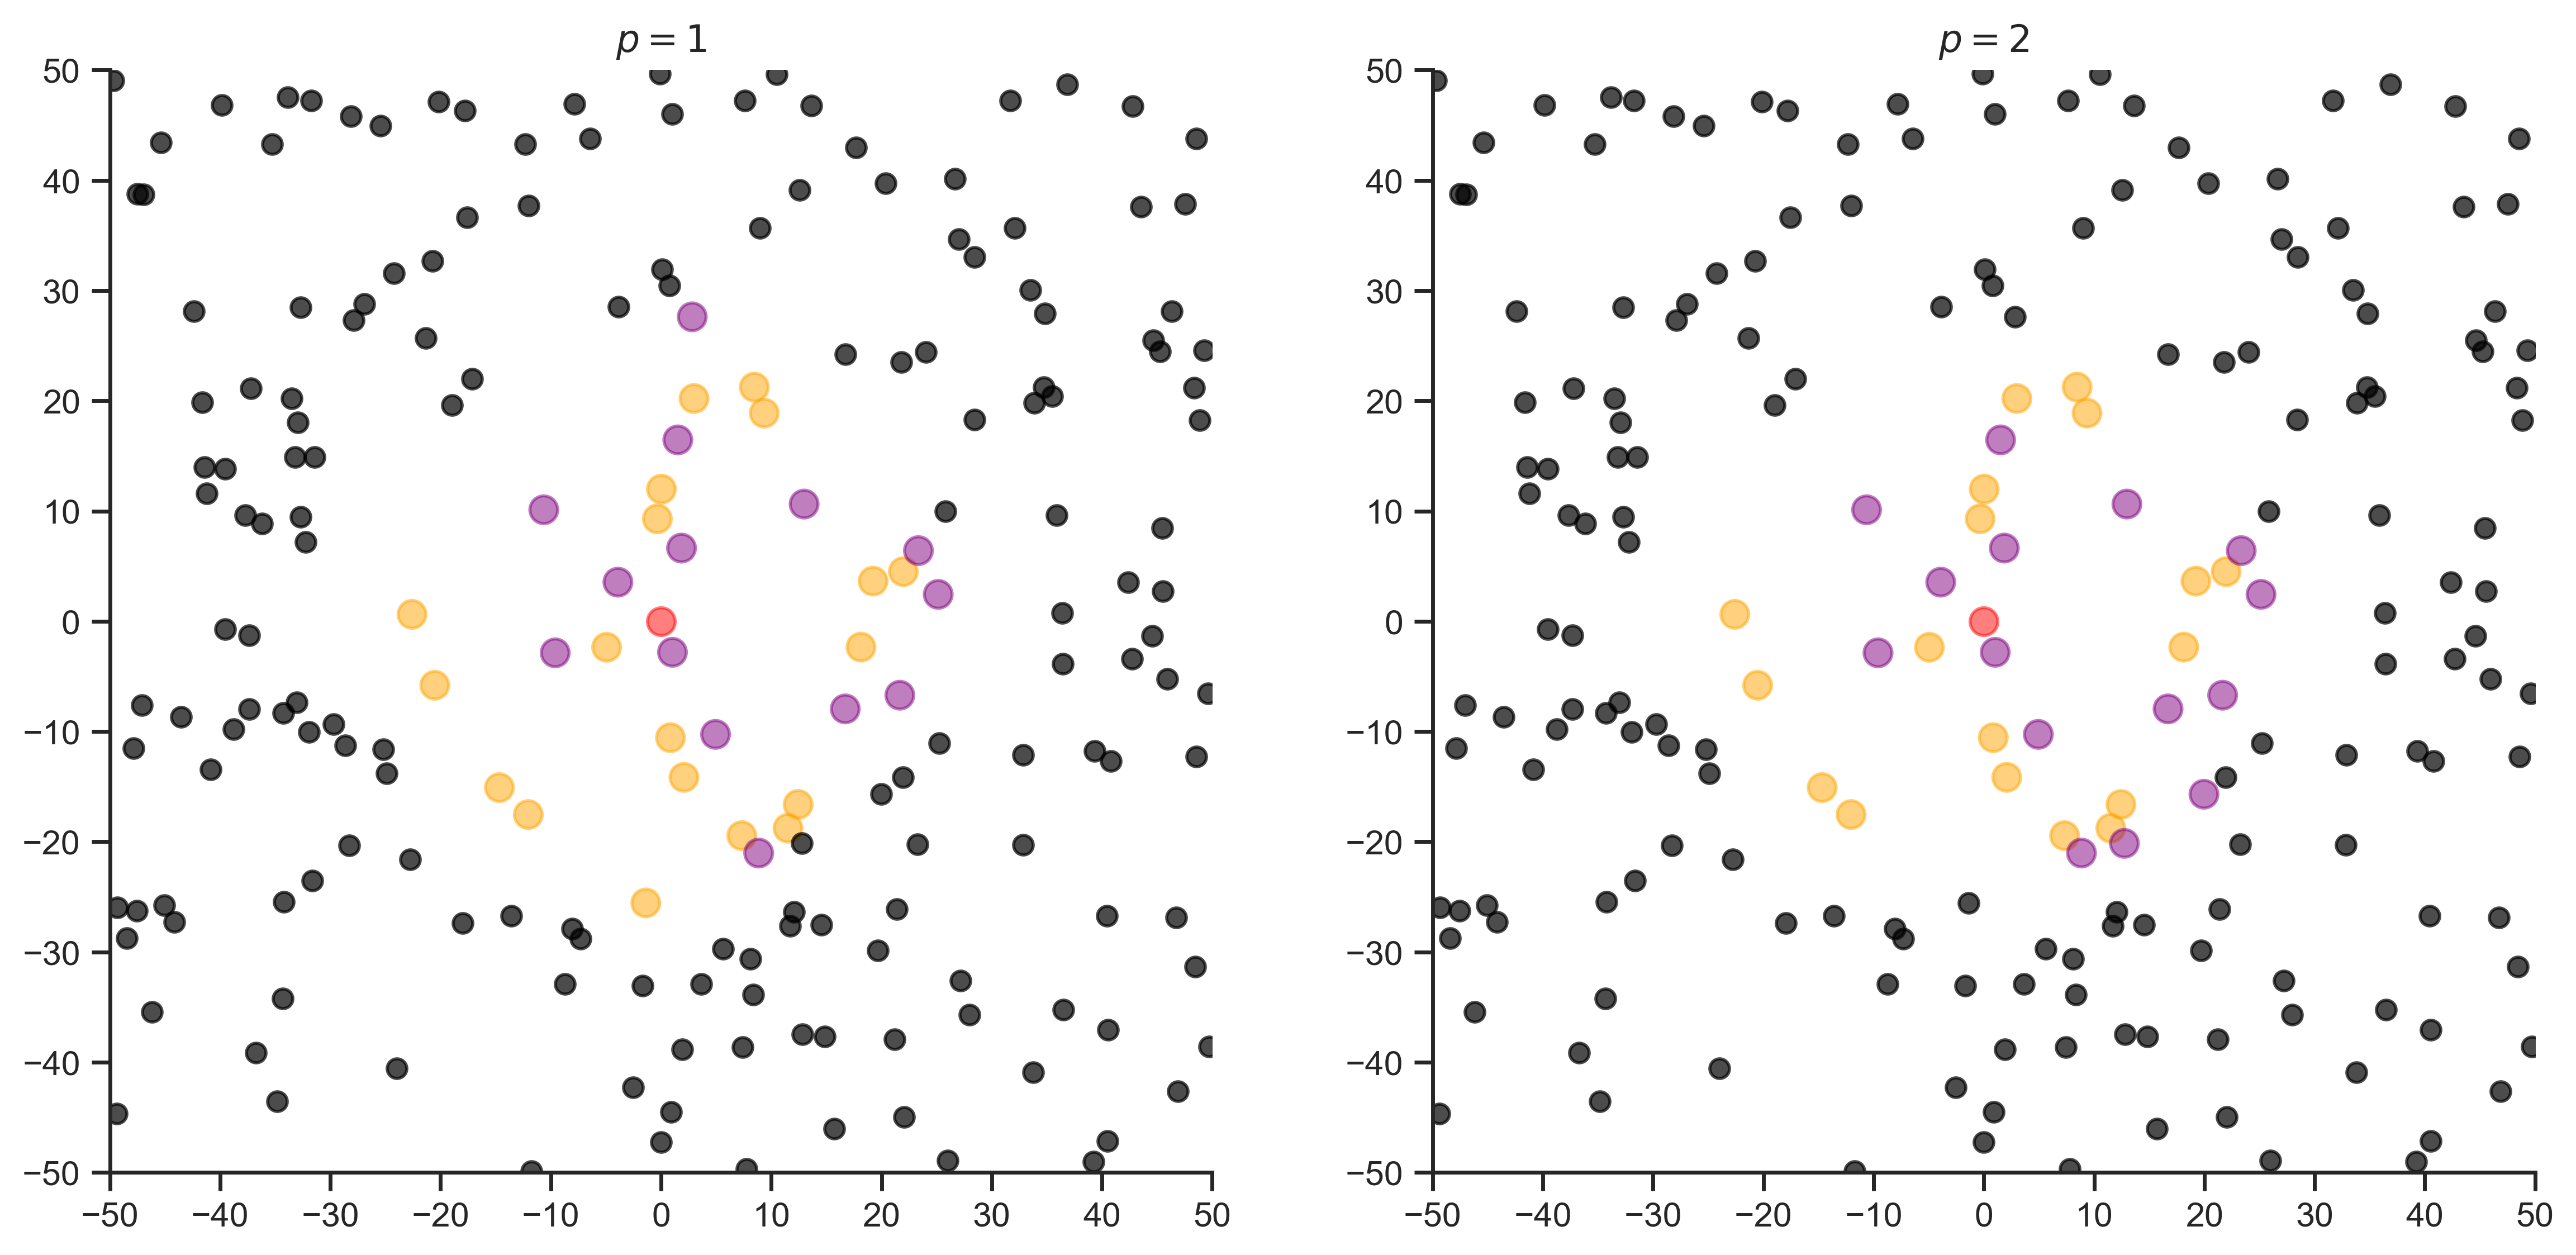

In [7]:
knnBinClf(k=33, pnorms=[1, 2])

In [8]:
x = np.linspace(-t, t, t + 1, dtype=int)
X = np.stack(np.meshgrid(x, x), -1).reshape(-1,2)
y = np.random.choice(colors, (t + 1)**2)
aes_voting = aes_watching = {'marker': 's', 's': 50, 'alpha': 0.85}

knnResult(class_='purple', Minkowski_p_norm=1, k=1001, nvotes=519, percentage=51.8)
knnResult(class_='purple', Minkowski_p_norm=2, k=1001, nvotes=522, percentage=52.1)


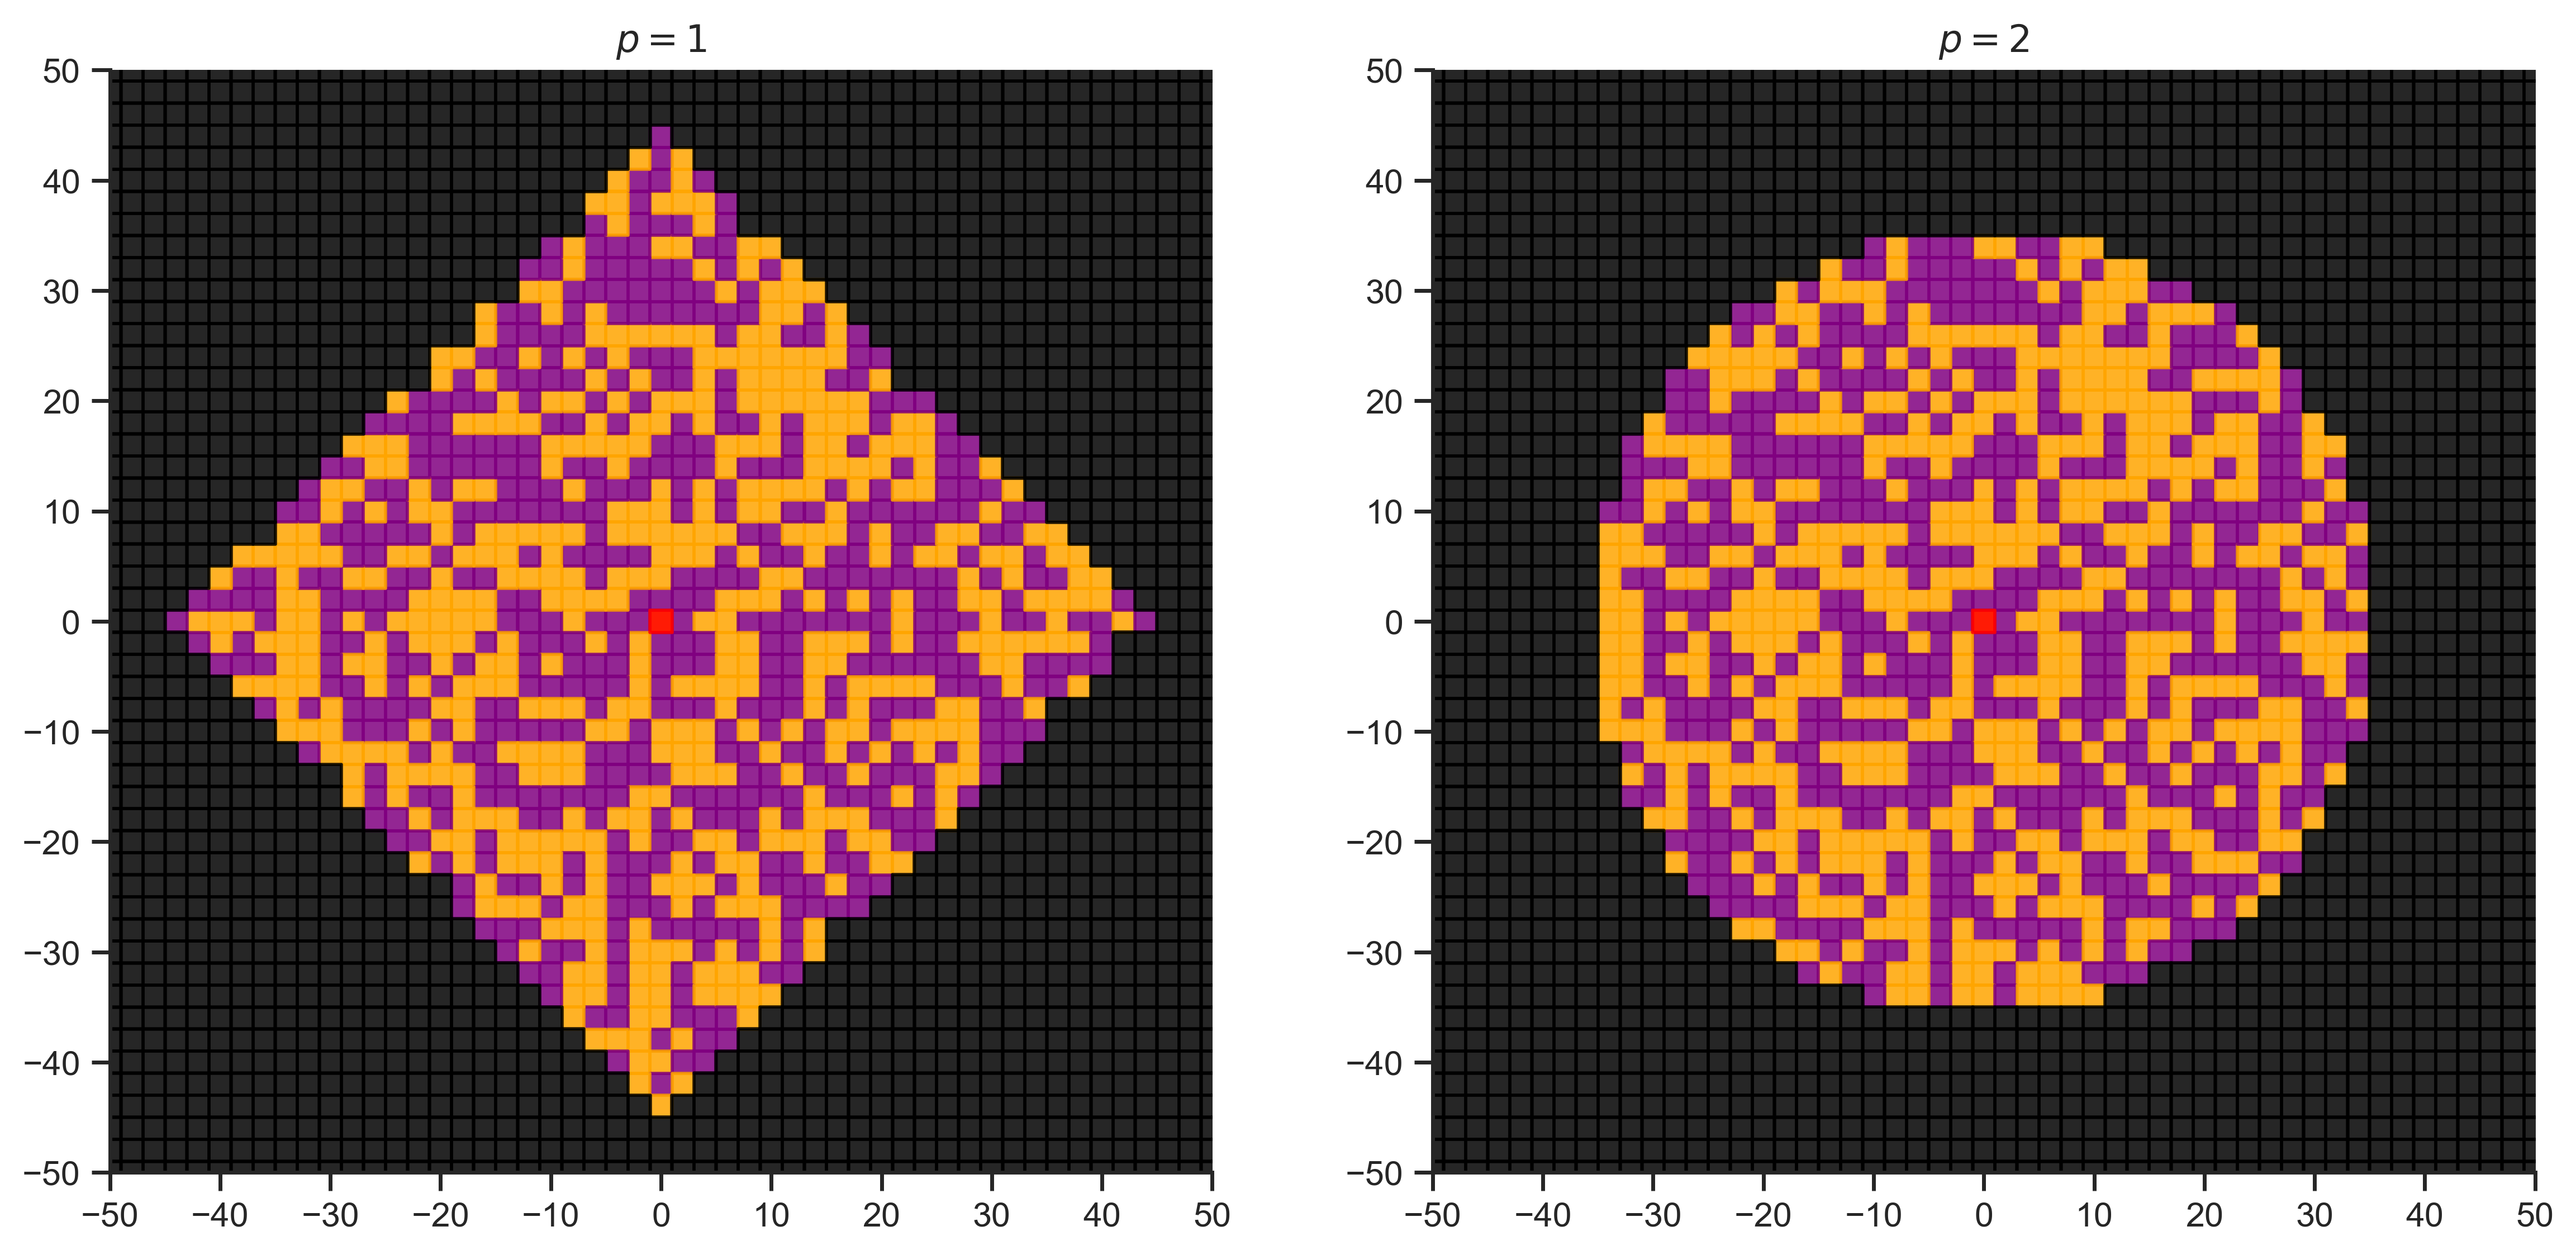

In [9]:
knnBinClf(k=1001, pnorms=[1, 2])

knnResult(class_='purple', Minkowski_p_norm=100, k=1001, nvotes=525, percentage=52.4)


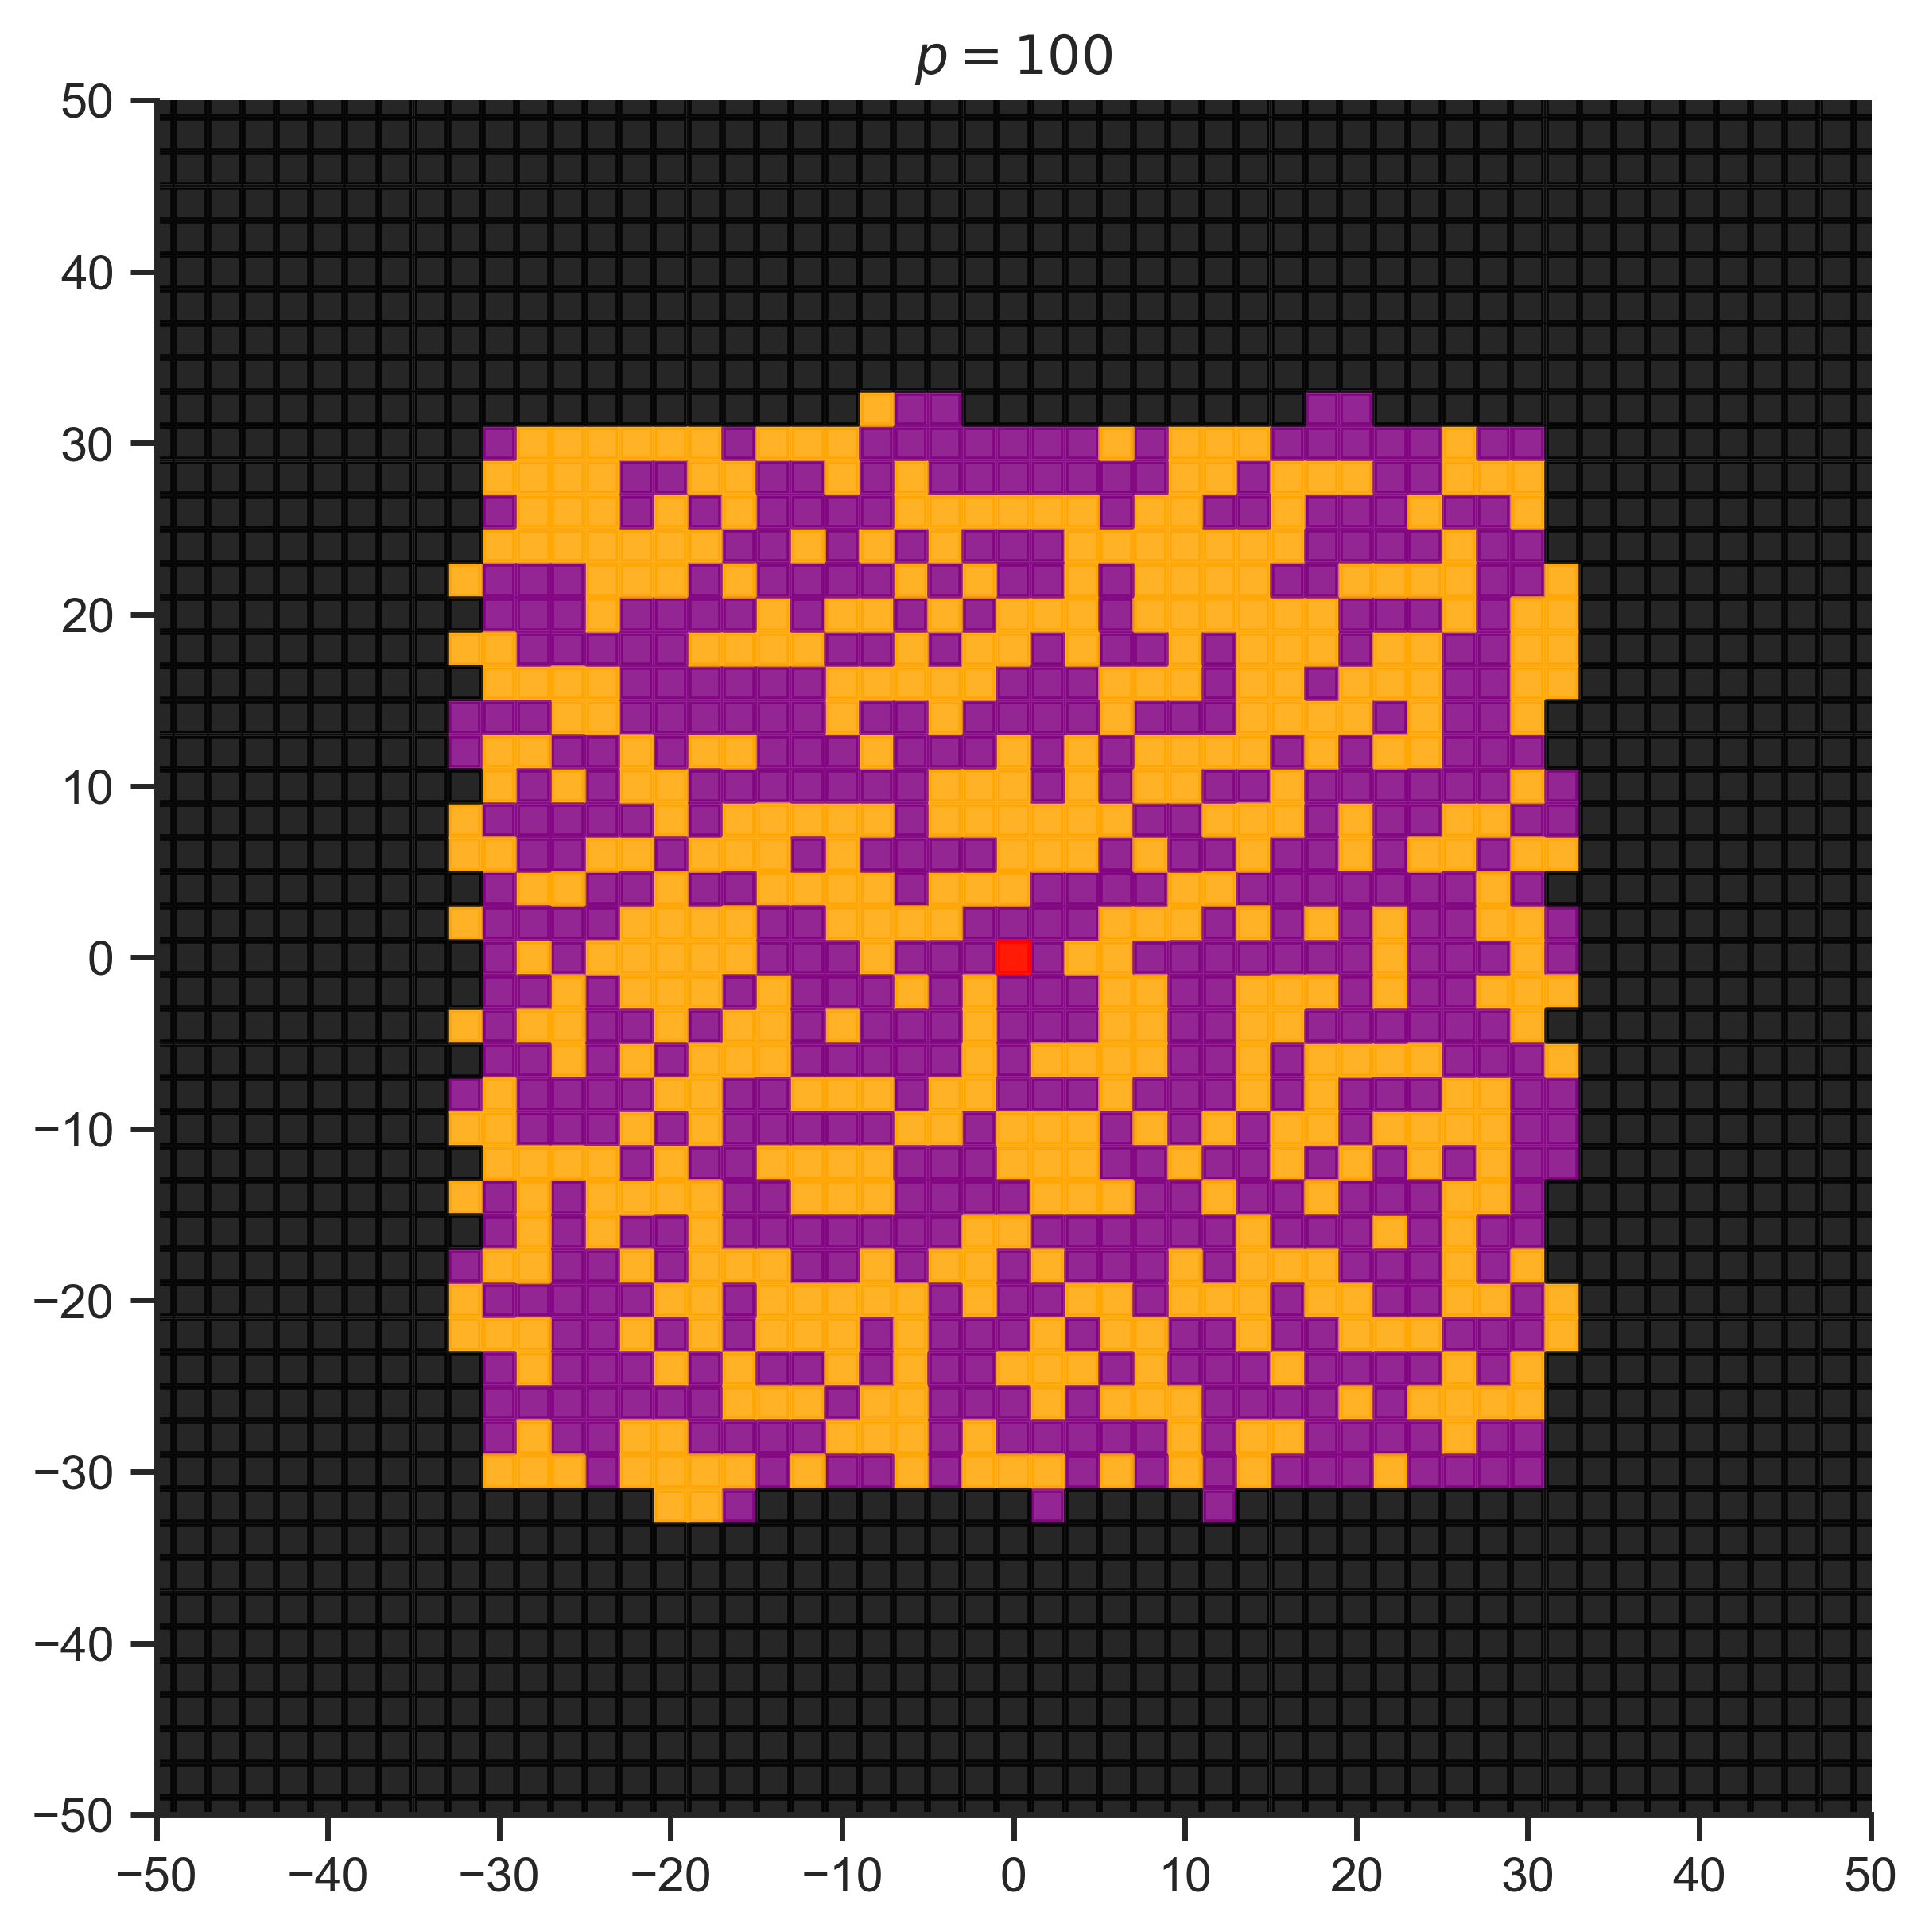

In [10]:
knnBinClf(k=1001, pnorms=[100])

Алгоритм kNN часто называют __ленивым__, так как обучение происходит лишь в момент предсказания. Грубо говоря, обучение состоит просто в хранении тренировочного набора данных.

На практике признаки могут иметь разные единицы измерения, что может искажать реальное расстояние между объектами. Один из способов решения проблемы – __нормализация данных__, например, переходом к относительным значениям с помощью линейной нормировки:

$$X'_i = \frac{X_i - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$$

[__sklearn.preprocessing.MinMaxScaler__](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn-preprocessing-minmaxscaler)

***
## <a id='toc1_4_'></a>[__Взвешенный kNN__](#toc0_)

Этот метод - "тайбрейк" на случай равного распределения голосов между классами при обычной kNN-классификации.  Каждому объекту тренировочных данных $x_i$ приписывается некоторый вес $w_i$, зависящий, вообще говоря, от тестового объекта $z$, т.е. $w_i = w_i(x_i, z), \, i \in \{1,2, \dots ,n\}$. __Тестовому наблюдению приписывается тот класс, суммарный вес представителей которого среди $k$ ближайших соседей наибольший__ (или один из таких классов, если их несколько).

Один из способов задания весов основан на близости тестируемого объекта по отношению к другим. Например, в качестве веса $w_i$ можно взять величину, обратно пропорциональную квадрату расстояния между объектами $x_i$ и $z$:

$$w_i = w_i(x_i,z) = \frac{1}{d^2(x_i,z)}.$$

Выбранные веса увеличивают значимость ближайших объектов и уменьшают значимость более дальних объектов.

***
## <a id='toc1_5_'></a>[__Алгоритмы и эмпирический риск__](#toc0_)

Пусть $X$ - множество всевозможных объектов, а $Y$ - множество откликов. Отображение

$$a: X \to Y$$

называется __алгоритмом__. Иначе говоря, алгоритм это функция, сопоставляющая произвольному объекту некоторый отклик.

Пусть $a: X \to Y$ - алгоритм. __Функция потерь__ (_loss function_) $L(a,x)$ - это произвольная неотрицательная функция, характеризующая величину ошибки алгоритма $a$ на объекте $x$.

Пусть $x_1,x_2, \dots ,x_n \in X$ - некоторый набор данных, $a(x): X \to Y$ - алгоритм, $L(a,x)$ - функция потерь. __Функционалом потерь__ (эмпирическим риском, _empirical risk_, или функционалом средних потерь) называется функционал

$$Q(a,L,x_1, \dots ,x_n) = \frac{1}{n} \sum_{i=1}^n L(a,x_i).$$

В качестве функции потерь при решении задачи классификации часто используют __индикаторную функцию__

$$L(a,x) = \text{I}(a(x) \ne y(x)) = \begin{cases}1, & \text{если отклик} \; y(x) \; \text{не совпал с} \; a(x) \\ 0, & \text{иначе}\end{cases}$$

Функционал потерь

$$Q(a,L,x_1, \dots ,x_n) = \frac{1}{n} \sum_{i=1}^n \text{I}(a(x_i) \ne y(x_i))$$

выдает долю неправильных ответов построенного классификатора на наборе данных $x_1,x_2, \dots ,x_n$.

***
## <a id='toc1_6_'></a>[__k-блочная кросс-валидация (k-fold cross-validation)__](#toc0_)

1. Пусть исходный набор данных разделен на $D_{\text{train}}$ и $D_{\text{test}}$.
2. Набор данных $D_{\text{train}}$ разбивается на $k$ непересекающихся примерно одинаковых по размеру блоков (множеств):

$$D_{\text{train}} = D_1 \cup D_2 \dots \cup D_k.$$

3. Пусть $i$ меняется в диапазоне $\{1,2, \dots ,k\}$.

(a) Производится обучение выбранного алгоритма $a(x)$ на множестве

$$D^i_{\text{train}} = D_{\text{train}} \setminus D_i.$$

(b) Производится тестирование выбранного алгоритма $a(x)$ на множестве $D^i_{\text{test}} = D_i$ и вычисляется значение

$$\text{Loss}_i(a) = Q(a,L,D^i_{\text{test}}).$$

4. Финальная оценка ошибки алгоритма $a(x)$ в результате $k$-блочной кросс-валидации такова:

$$\text{Loss}(a) = \frac{1}{k} \sum_{i=1}^k \text{Loss}_i(a).$$

5. Шаги $3-4$ повторяются для каждого исследуемого (сравниваемого) алгоритма.

6. В качестве лучшего алгоритма выбирается тот $a$, значение $\text{Loss}(a)$ которого наименьшее.

7. Выбранный лучший алгоритм обучается на всем наборе данных $D_{\text{train}}$ и тестируется на наборе $D_{\text{test}}$. Полученная ошибка $Q(a,L,D_{\text{test}})$ считается "средней" ошибкой лучшего алгоритма.

Итак, по сути дела тренировочный набор данных делится на несколько более маленьких кусочков, каждый из которых на своей итерации выступает тестовым набором данных – набором данных для оценивания алгоритма. Финальная оценка каждого алгоритма – это усреднение оценок на каждой итерации.

In [11]:
X = np.array([[10, 1], [7, 4], [8, 3], [2, 2], [1, 5],
              [3, 3], [2, 1], [3, 2], [2, 8], [9, 8],
              [4, 10], [2, 9], [3, 7], [8, 7]])

y = np.array([1, 1, 1, 2, 2, 2, 2, 2, 3, 1, 3, 3, 3, 1])

In [12]:
def knnWeightedCV(X, y, *, nfolds, k):
    """
    Взвешенный kNN-классификатор с кросс-валидацией. 
    """
    all_indices = np.arange(y.size)
    folds = np.array_split(all_indices, nfolds)
    losses = []
    for fold in folds:
        mask = np.isin(all_indices, fold)  # picks validation part
        distances = cdist(X[mask], X[~mask])  # len valid x len train
        sort_indices = np.argsort(distances)[:,:k]  # first k columns
        distances = np.take_along_axis(distances, sort_indices, axis=1)
        response_weights = zip(y[~mask][sort_indices], distances**(-2))
        aggregated = [npi.group_by(y).sum(w) for y, w in response_weights]
        y_pred = np.array([a[0][np.argmax(a[1])] for a in aggregated])
        losses.append(np.not_equal(y_pred, y[mask]).sum() / fold.size)
    return np.mean(losses)

In [13]:
[knnWeightedCV(X, y, nfolds=3, k=k) for k in (3, 4)]

[0.19999999999999998, 0.06666666666666667]

***
## <a id='toc1_7_'></a>[__Наивный байесовский классификатор__](#toc0_)

Пусть $X$ – это множество объектов, каждый из которых описывается $p$ признаками – случайными величинами $X_1,X_2, \dots ,X_p$ и откликом $Y$ (для простоты отклик принимает конечное множество значений). Будем также предполагать, что все случайные величины $X_1,X_2, \dots ,X_p$ имеют дискретное распределение с конечным множеством значений. Наша задача назначить новому, тестовому объекту с предикторами $X_1,X_2, \dots ,X_p$, одну из меток классов из множества $Y$.

Сначала вычислим вероятности отнесения нового объекта к каждому из имеющихся классов, то есть набор вероятностей:

$$P(\text{класс} = y | X_1,X_2,\dots,X_p), \quad y \in Y$$

Выражение показывает вероятность отнесения к классу $y$ объекта, обладающего набором атрибутов $X_1,X_2,\dots,X_p$.

Пользуясь формулой Байеса:

$$y^* = \argmax_{y \in Y} P(\text{класс} = y | X_1,X_2,\dots,X_p)$$ 

$$y^* = \argmax_{y \in Y} \frac{P(X_1,X_2,\dots,X_p | \text{класс} = y)\;P(\text{класс} = y)}{P(X_1,X_2,\dots,X_p)}$$

$P(X_1,X_2,\dots,X_p)$ не зависит от $y$ и потому не влияет на максимизацию.

Вероятности $P(\text{класс} = y)$ оцениваются по частоте встречаемости классов в тренировочном наборе данных:

$$P(\text{класс} = y) = \frac{\sum_{i=1}^n \text{I}(y_i = y)}{n},$$

где $n$ - общее количество тренировочных элементов.

__Наивность__ байесовского классификатора заключается в предположении условной независимости предикторов при условии данной метки класса:

$$P(X_1,X_2,\dots,X_p | \text{класс} = y) = \prod_{i=1}^p P(X_i | \text{класс} = y)$$

В контексте классификации, например, писем или текстов, "наивное" ограничение означает, что слова на одну и ту же тему появляются в тексте независимо друг от друга.

$P(X_i | \text{класс} = y)$ также оцениваются по частоте данного значения $z_i$ предиктора среди тренировочных данных класса $y$:

$$P(X_i | \text{класс} = y) = \frac{\sum_{k=1}^n \text{I}(x_{ki} = z_i, y_k = y)}{\sum_{k=1}^n \text{I}(y_k = y)},$$

т.е. по отношению количества тренировочных элементов класса $y$, у которых $X_i = z_i$, к количеству тренировочных элементов класса $y$.

С учетом монотонности логарифма классификатор принимает вид:

$$y^* = \argmax_{y \in Y} \left(\ln P(\text{класс} = y) + \sum_{i=1}^p \ln P(X_i | \text{класс} = y)\right)$$

Чтобы вернуться к вероятностям отнесения к классам, необходимо избавиться обратно от логарифмов и нормировать результаты:

$$F(y) = \ln P(\text{класс} = y) + \sum_{i=1}^p \ln P(X_i | \text{класс} = y)$$

$$P(\text{класс} = y^* | X_1,X_2,\dots,X_p) = \frac{e^{F(y^*)}}{\sum_{y \in Y} e^{F(y)}}$$

[__scipy.special.softmax__](https://scipy.github.io/devdocs/reference/generated/scipy.special.softmax.html#scipy-special-softmax)

Введенные выше оценки вероятностей являются оценками ММП.

In [14]:
data = [['sunny', 'hot', 'wet', 'n', 'n'],
        ['sunny', 'hot', 'wet', 'y', 'n'],
        ['cloudy', 'hot', 'wet', 'n', 'y'],
        ['rainy', 'cool', 'dry', 'n', 'y'],
        ['rainy', 'cold', 'dry', 'n', 'y'],
        ['rainy', 'cold', 'dry', 'y', 'n'],
        ['cloudy', 'cool', 'wet', 'y', 'y'],
        ['cloudy', 'cool', 'wet', 'n', 'n'],
        ['cloudy', 'cool', 'wet', 'y', 'y']]

headers = 'Weather', 'Temperature', 'Humidity', 'Wind', 'Event'
predictors = headers[:-1]

# Состоится ли матч при данных значениях предикторов?
tested = ['cloudy', 'cold', 'wet', 'y']

df = pd.DataFrame(data, columns=headers)
df

,Weather,Temperature,Humidity,Wind,Event
0,sunny,hot,wet,n,n
1,sunny,hot,wet,y,n
2,cloudy,hot,wet,n,y
3,rainy,cool,dry,n,y
4,rainy,cold,dry,n,y
5,rainy,cold,dry,y,n
6,cloudy,cool,wet,y,y
7,cloudy,cool,wet,n,n
8,cloudy,cool,wet,y,y


In [15]:
target_distr = df.Event.value_counts(normalize=True)
target_distr  # распределение вероятностей целевой переменной

Event
y    0.555556
n    0.444444
Name: proportion, dtype: float64

In [16]:
F = []

for response in target_distr.index:
    f = np.log(target_distr[response])  # пуск счетчика вероятностью класса
    subframe = df[df.Event == response]
    n = subframe.shape[0]
    for predictor, value in zip(predictors, tested):
        f += np.log((subframe[predictor] == value).sum() / n)
    F.append(f)
    
F

[-4.135166556742355, -4.564348191467836]

In [17]:
naiveBayesClfResult = lambda fields: namedtuple('naiveBayesClfResult', fields)
naiveBayesClfResult(target_distr.index)(*softmax(F))

naiveBayesClfResult(y=0.6056782334384858, n=0.3943217665615141)

***
## <a id='toc1_8_'></a>[__Классификация писем. Сглаживание по Лапласу__](#toc0_)

Ситуация, когда количество предикторов у объекта заранее известно, бывает не всегда. Рассмотрим задачу классификации писем на спам и не спам. Количество предикторов в каждом письме равно количеству входящих в него слов. Составим обобщенный словарь $V$ слов из трех тренировочных текстов:

* _Win a million rubles_ – "спам";
* _Ruble drops again_ – "не спам";
* _A million ways to get rich_ – "спам".

In [18]:
data = [['win', 1, 0], ['million', 2, 0], ['ruble', 1, 1], ['again', 0, 1],
        ['drops', 0, 1], ['ways', 1, 0], ['get', 1, 0], ['rich', 1, 0]]

headers = 'Predictor', 'Spam', 'Ham'
categories = headers[1:]

proba = dict(zip(categories, (2/3, 1/3)))

df = pd.DataFrame(data, columns=headers)
df.set_index('Predictor', inplace=True)
df  # vocabulary V

,Spam,Ham
Predictor,,
win,1,0
million,2,0
ruble,1,1
again,0,1
drops,0,1
ways,1,0
get,1,0
rich,1,0


Оценка $P(X | \text{класс} = y)$ может столкнуться с проблемой. На примере слова _win_:

$$P(X = \text{win}|\text{класс} = \text{не спам}) = 0,$$

а это значит, что письмо, содержащее слово _win_, никогда не будет отнесено к
категории "не спам", даже если все остальные слова в письме - _again_ и _drops_ - явные индикаторы того, что письмо спамом не является. Выход - применить так называемое __сглаживание по Лапласу__ - предположить, что мы видели каждое слово на один раз больше:

$$P(X|\text{класс} = y) = \frac{1 + \text{количество слов}\;X\;\text{в классе}\;y}{|V| + r + \text{количество слов в классе}\;y}, \quad y \in \{\text{спам,\;не спам}\},$$

где $r$ - количество слов в письме, которых нет в словаре.

In [19]:
tested = 'Get rich with ruble'
tested = tested.lower().split()
tested

['get', 'rich', 'with', 'ruble']

In [20]:
r = len(set(tested) - set(df.index))
r  # 'with'

1

In [21]:
F = []

for cat in categories:
    f = np.log(proba[cat])
    for word in tested:
        q = df.loc[word, cat] if word in df.index else 0
        f += np.log((1 + q) / (df.shape[0] + r + df[cat].sum()))
    F.append(f)
    
naiveBayesClfResult(categories)(*softmax(F))

naiveBayesClfResult(Spam=0.7168141592920352, Ham=0.28318584070796476)

***
## <a id='toc1_9_'></a>[__Решение задач ВШЭ__](#toc0_)

***
### <a id='toc1_9_1_'></a>[__Задание 1__](#toc0_)
1. Получите выборку с помощью следующего вызова:
```
make_moons(n_samples=1000, noise=0.5, random_state=10)
```
2. Разбейте выборку на `train` и `test` с помощью функции `train_test_split`. Через аргументы функции зафиксируйте `random_state=10` и `test_size=0.5`.

3. Обучите класс `GridSearchCV` на обучающей выборке. Переберите параметр `n_neighbors` от $1$ до $20$. Чтобы получить детерменированный результат, передайте в параметр `cv` объект класса `KFold(n_splits=5, random_state=10)`. Этот класс будет отвечать за разбиение выборки во время кросс-валидации.

Напишите метрику качества (`accuracy`), которая получается, если применить обученный `GridSearchCV` к тестовой выбоке.

In [22]:
X, y = make_moons(n_samples=1000, noise=0.5, random_state=10)

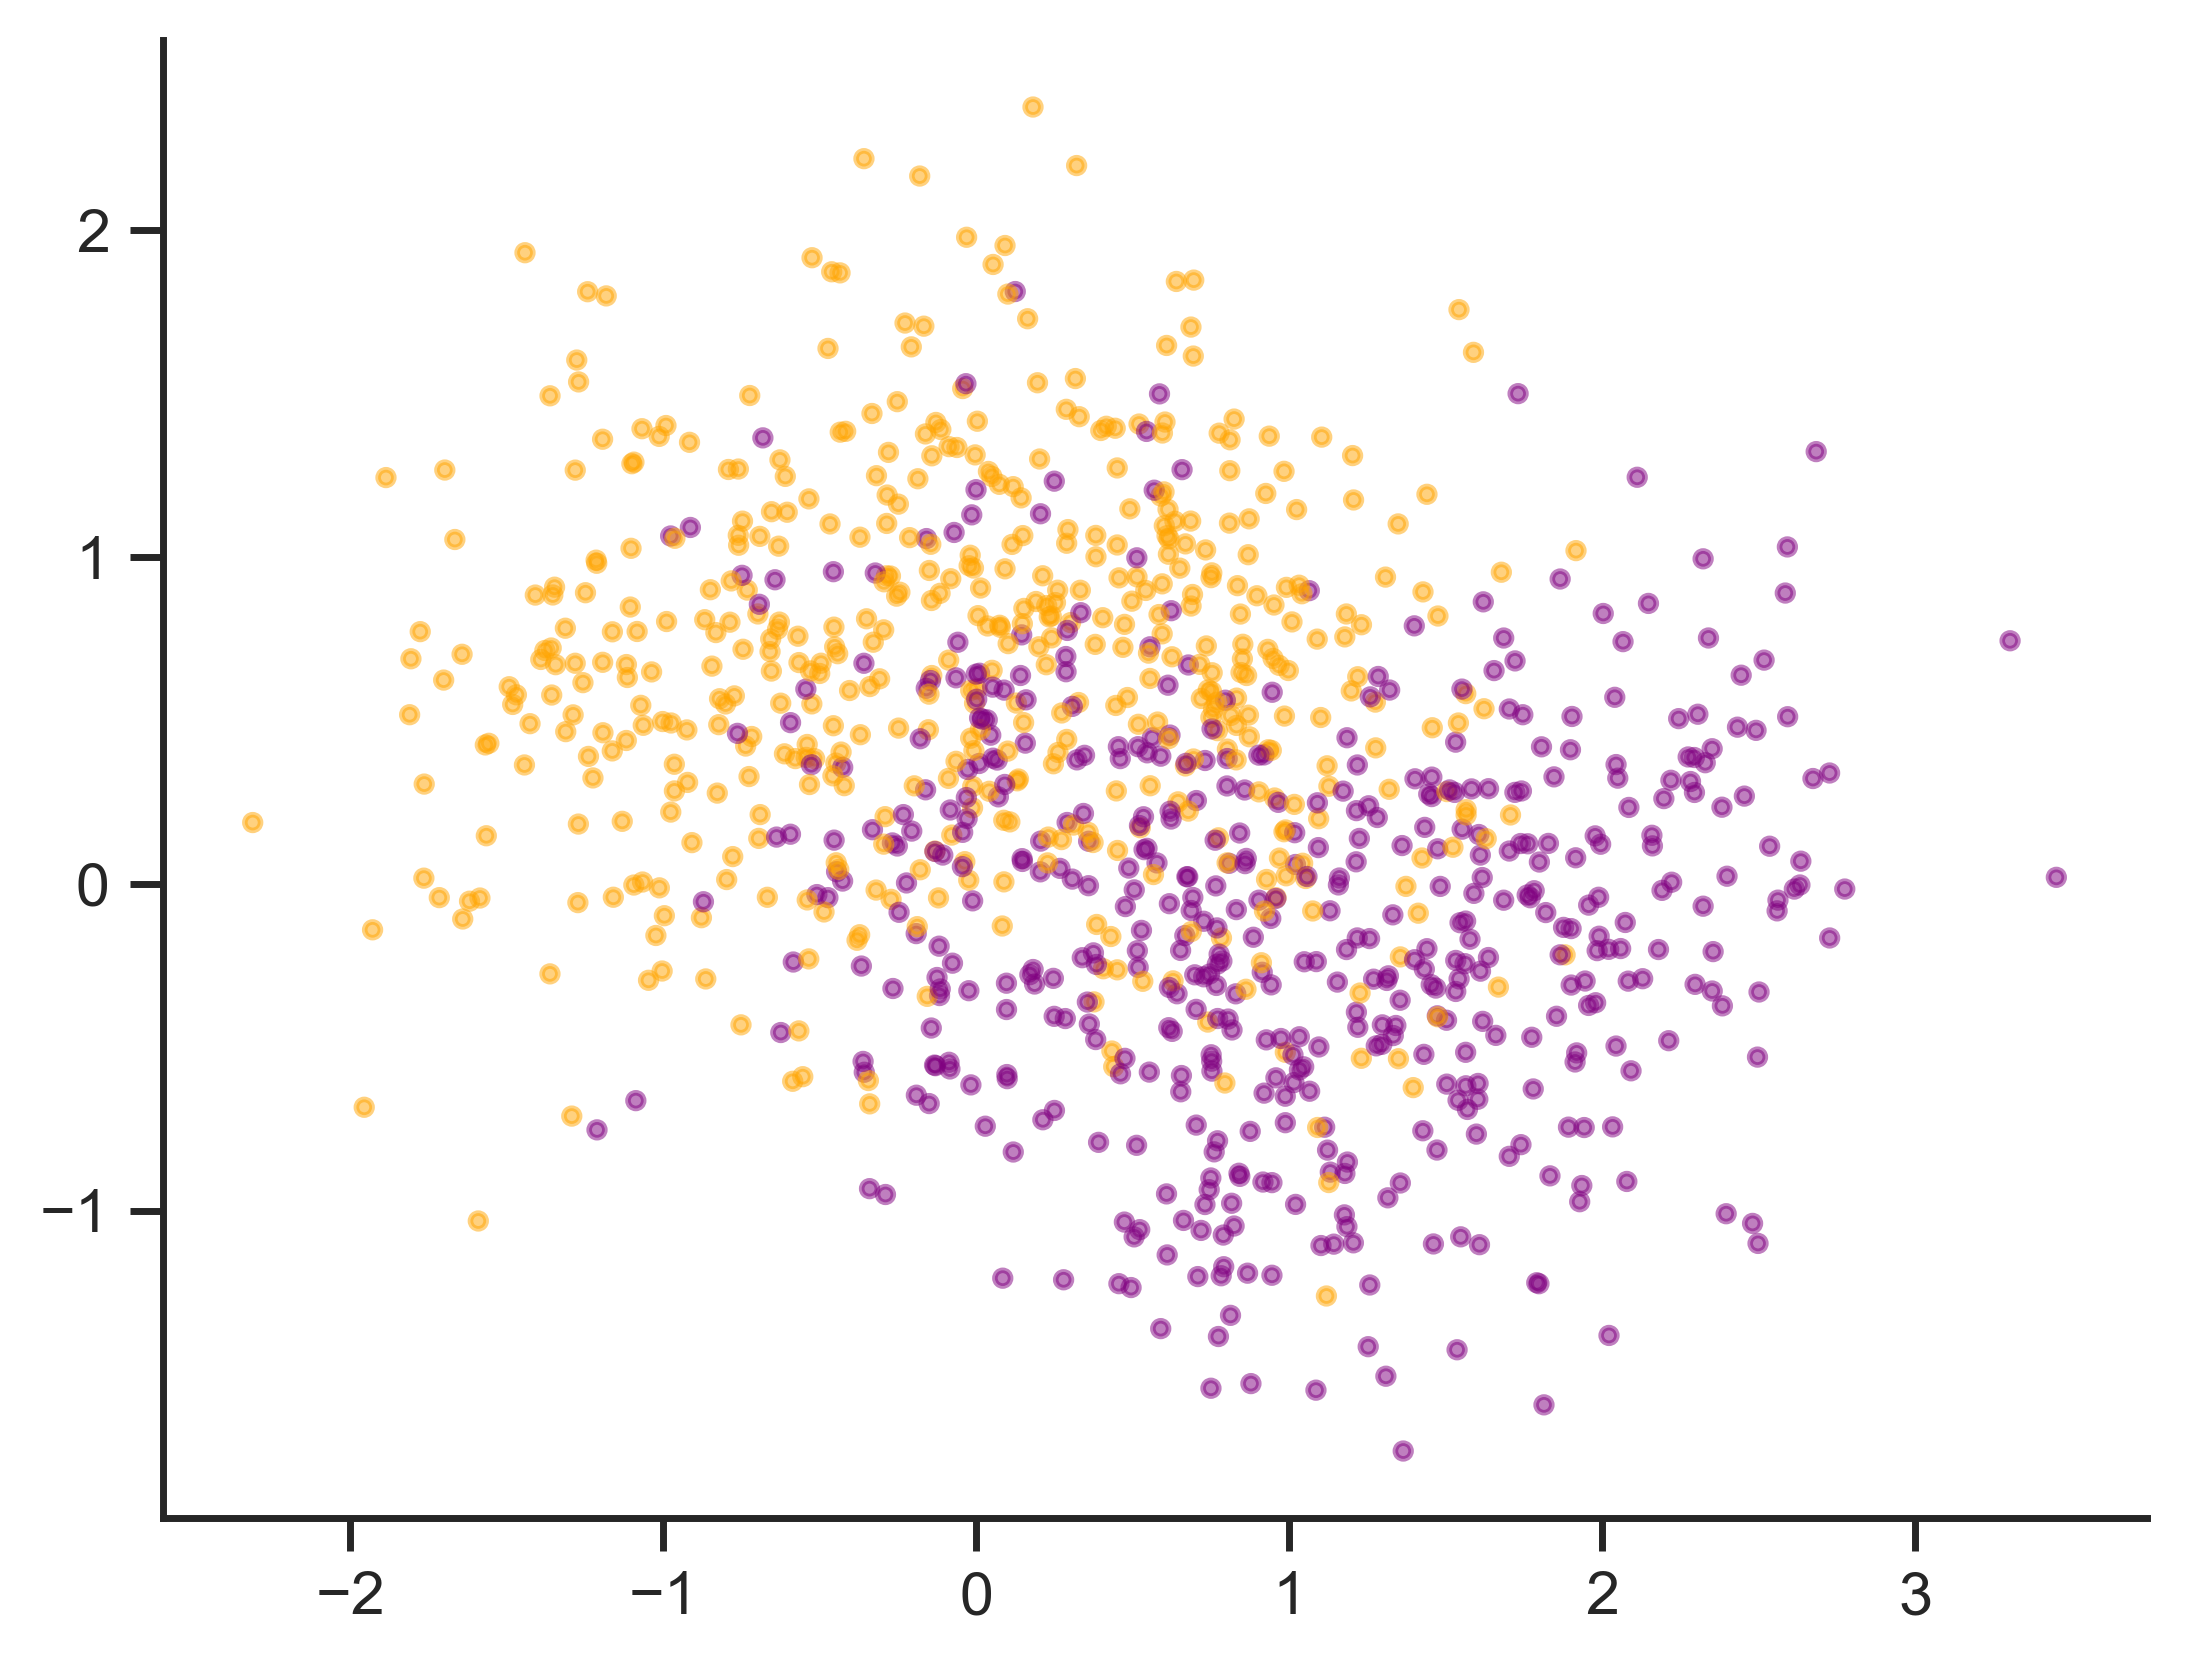

In [23]:
colors = np.where(y, 'purple', 'orange')
plt.scatter(*X.T, c=colors, s=8, alpha=0.5)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10
)

In [25]:
neighbors = range(1, 21)

In [26]:
gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={'n_neighbors': neighbors},
    cv=KFold(n_splits=5, shuffle=True, random_state=10)
)

gs.fit(X_train, y_train)
accuracy_score(y_test, gs.predict(X_test))

0.8

[__sklearn.model_selection.GridSearchCV.predict__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.predict)
> Call predict on the estimator with the best found parameters.

In [27]:
gs.best_params_

{'n_neighbors': 20}

In [28]:
clf = KNeighborsClassifier(**gs.best_params_)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.8

***
### <a id='toc1_9_2_'></a>[__Задание 2__](#toc0_)

Напишите функцию `train_grid_search`. Функция принимает выборку на вход и создает объект `GridSearchCV`, который перебирает соседей от $1$ до $20$. Обучите объект `GridSearchCV`. Функция должна возвращать значение ключа `mean_test_score` у атрибута `cv_results_` объекта `GridSearchCV`. Это поле содержит информацию о значении метрики для каждого параметра.

Постройте график зависимости среднего значения метрики качества от количества соседей.

In [29]:
def train_grid_search(X, y):
    gs = GridSearchCV(
        KNeighborsClassifier(),
        param_grid={'n_neighbors': neighbors}
    )
    gs.fit(X, y)
    return gs.cv_results_['mean_test_score']

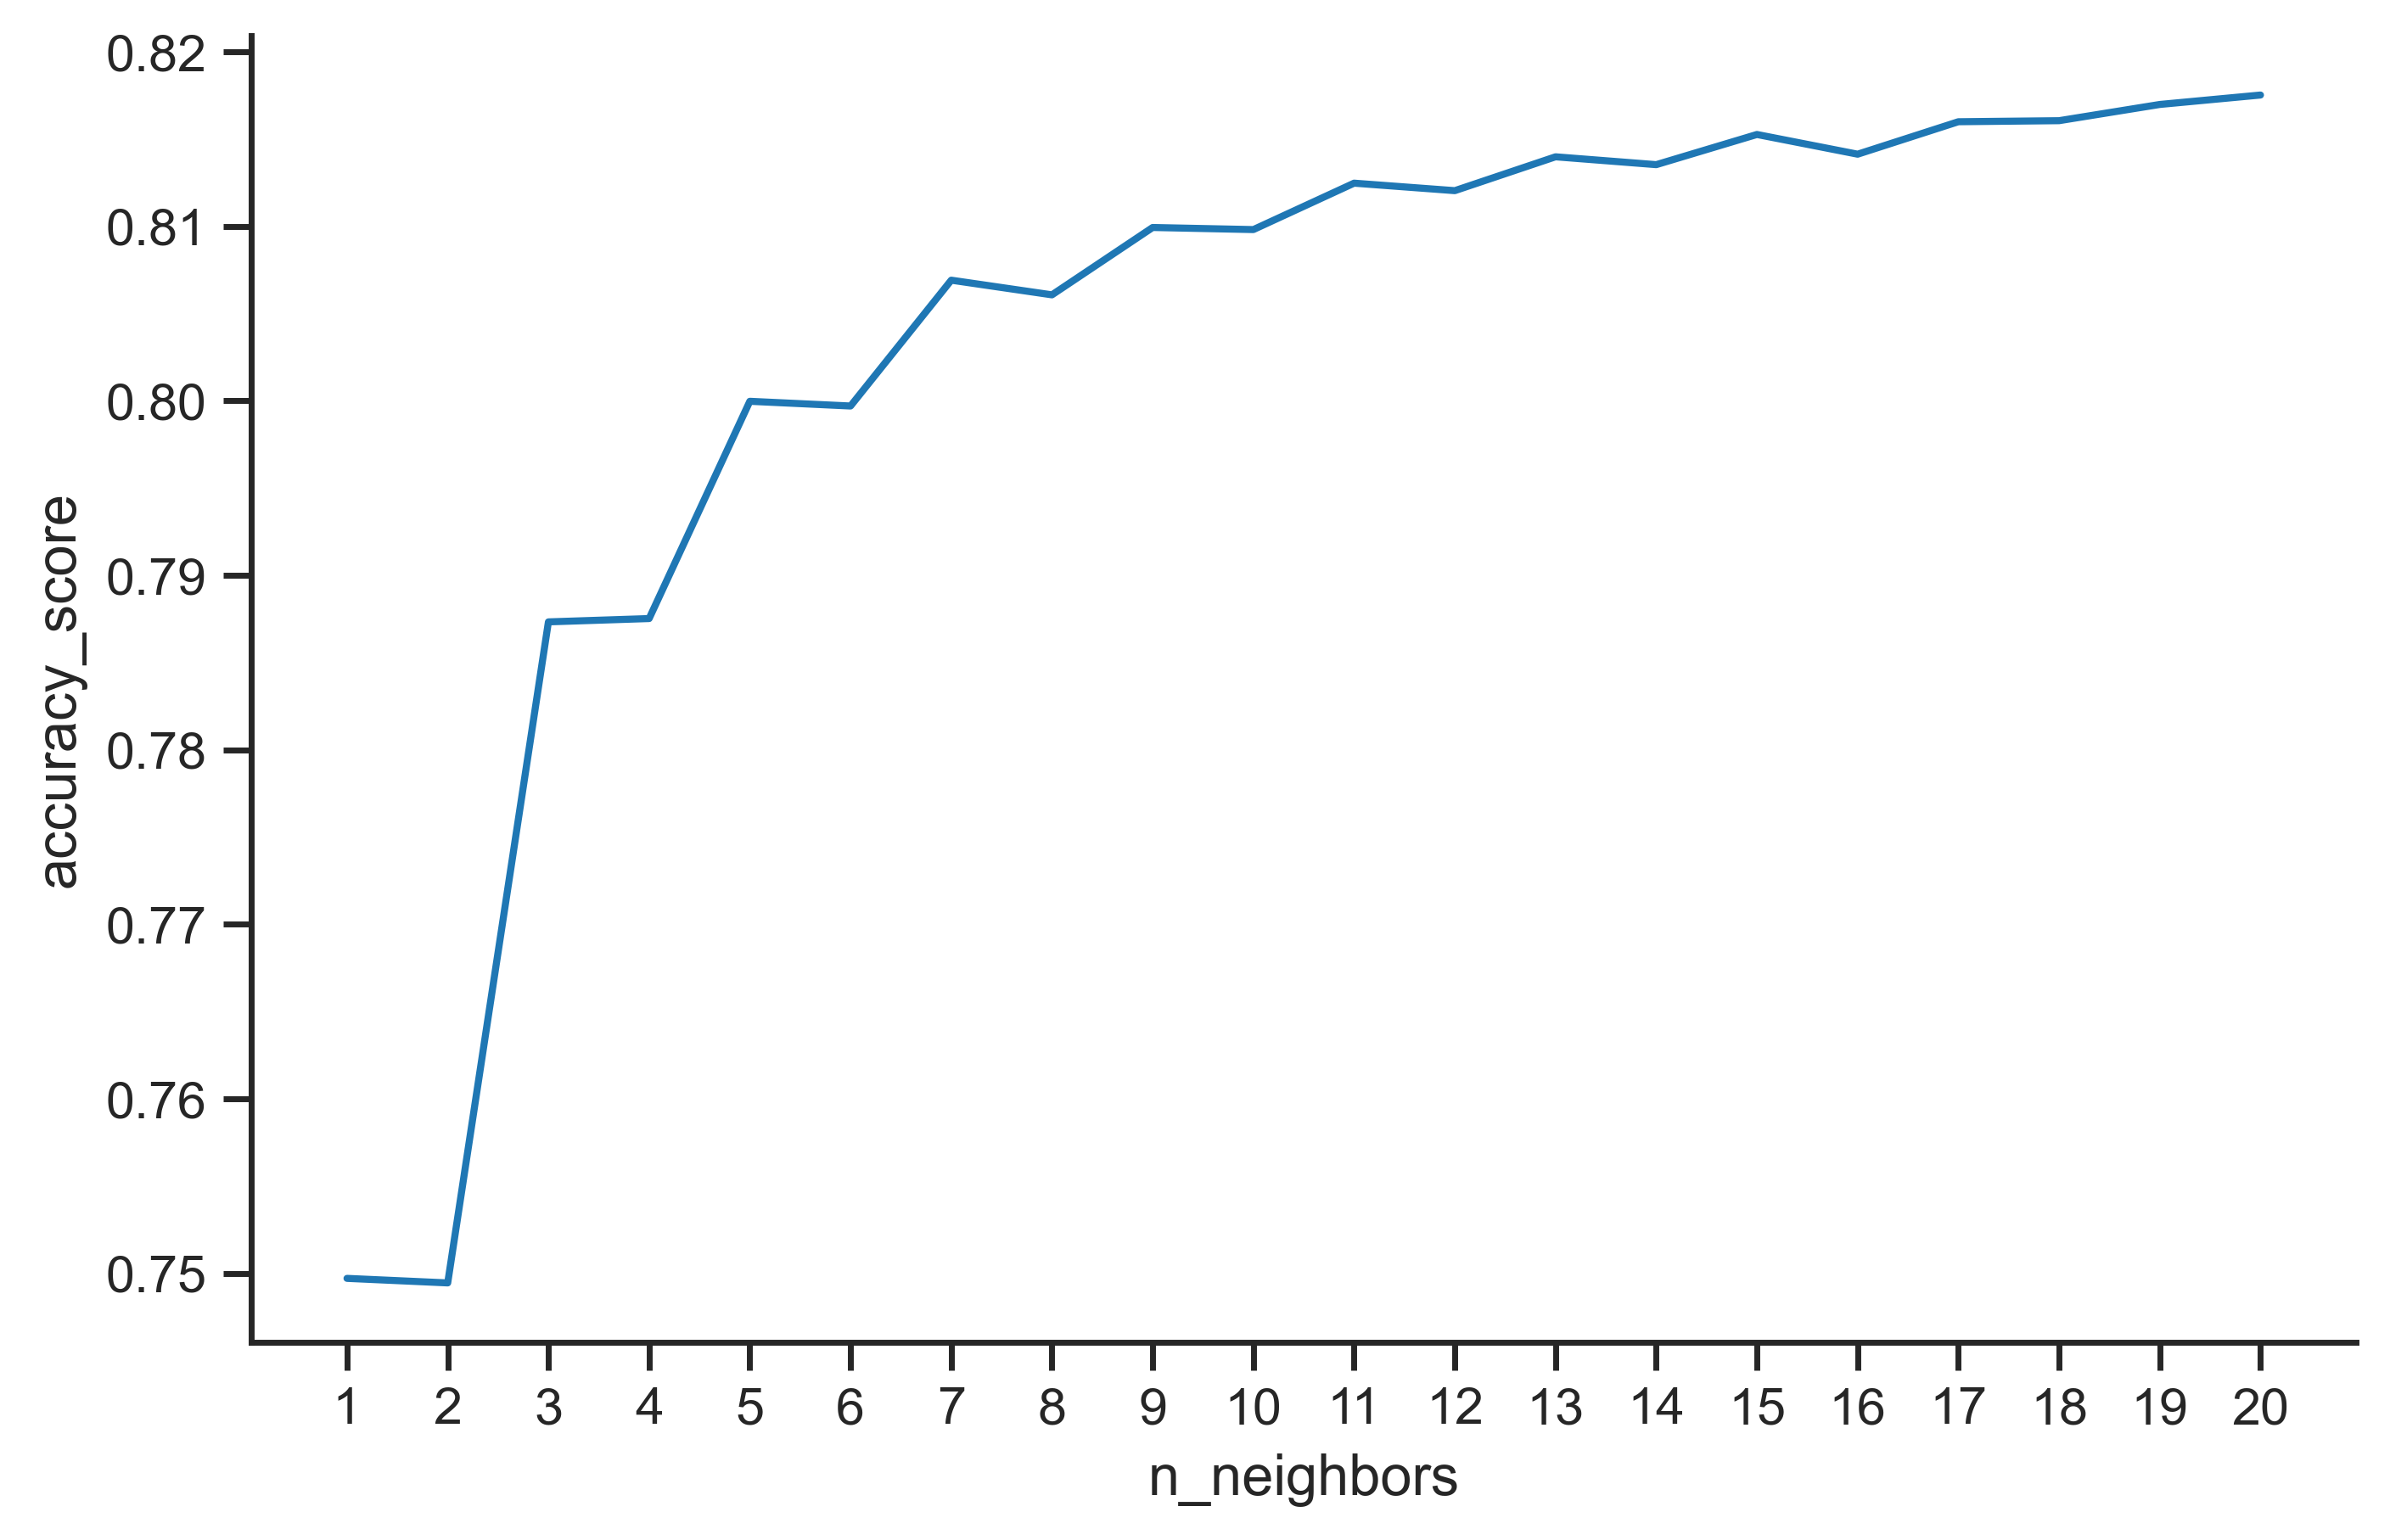

In [30]:
scores = []

for _ in range(100):
    X, y = make_moons(n_samples=1000, noise=0.5)
    scores.append(train_grid_search(X, y))

plt.figure(figsize=(8,5))
plt.plot(neighbors, np.mean(scores, axis=0))
plt.xticks(neighbors)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy_score')
plt.show()

In [31]:
pd.DataFrame(scores, columns=neighbors)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.769,0.768,0.820,0.808,0.826,0.830,0.833,0.832,0.831,0.837,0.826,0.833,0.830,0.829,0.833,0.831,0.833,0.837,0.837,0.840
1,0.727,0.733,0.768,0.761,0.780,0.785,0.792,0.782,0.795,0.790,0.798,0.797,0.808,0.804,0.802,0.799,0.802,0.802,0.802,0.798
2,0.734,0.734,0.774,0.775,0.798,0.799,0.793,0.787,0.799,0.799,0.803,0.799,0.798,0.796,0.801,0.802,0.797,0.796,0.800,0.801
3,0.747,0.754,0.792,0.793,0.802,0.806,0.815,0.810,0.816,0.807,0.810,0.812,0.811,0.807,0.813,0.809,0.813,0.810,0.816,0.813
4,0.742,0.740,0.779,0.763,0.785,0.781,0.800,0.793,0.801,0.796,0.798,0.796,0.799,0.801,0.801,0.796,0.806,0.802,0.804,0.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.741,0.754,0.781,0.800,0.808,0.807,0.818,0.813,0.821,0.816,0.822,0.811,0.816,0.809,0.812,0.806,0.811,0.804,0.812,0.816
96,0.759,0.763,0.802,0.794,0.808,0.805,0.822,0.808,0.823,0.821,0.827,0.822,0.828,0.828,0.832,0.831,0.829,0.829,0.833,0.827
97,0.748,0.721,0.792,0.773,0.808,0.803,0.818,0.827,0.825,0.827,0.832,0.839,0.833,0.830,0.837,0.832,0.834,0.831,0.832,0.835
98,0.739,0.734,0.784,0.783,0.784,0.788,0.799,0.793,0.793,0.794,0.797,0.795,0.797,0.793,0.796,0.787,0.789,0.794,0.798,0.795


`train_grid_search` возвращает массив из $20$ `accuracy_score` - по количеству перебираемых значений `n_neighbors`. При этом каждый отдельно взятый `accuracy_score` - результат усреднения по $5$ блокам:
> cv=None<br>
None, to use the default 5-fold cross validation

Усреднение результатов для $100$ выборок по строкам (вдоль столбцов) и дает средние значения `accuracy_score` для соответствующих значений `n_neighbors`.

***
### <a id='toc1_9_3_'></a>[__Задание 3__](#toc0_)

[__tensorflow.keras.datasets.mnist__](https://keras.io/api/datasets/mnist/)

In [32]:
images, labels = mnist.load_data()[0]
images.shape

(60000, 28, 28)

In [33]:
images = images.reshape(60_000, 28**2)

In [34]:
img_train, img_test, lab_train, lab_test = train_test_split(
    images, labels, test_size=0.2, random_state=0
)

clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(img_train, lab_train)
lab_pred = clf.predict(img_test)
accuracy_score(lab_test, lab_pred)

0.9575

***
### <a id='toc1_9_4_'></a>[__Задание 4__](#toc0_)

(В связке с __Заданием 3__)

Найдите примеры, классифицированные неправильно. Найдите и визуализируйте $6$ соседей неправильных предсказаний у любого ошибочного примера. Найти соседей точки можно с помощью метода `kneighbors`. Почему они были классифицированы неправильно?

In [35]:
# индекс первой ошибки классификатора
i = np.argmax(np.not_equal(lab_test, lab_pred))
i

33

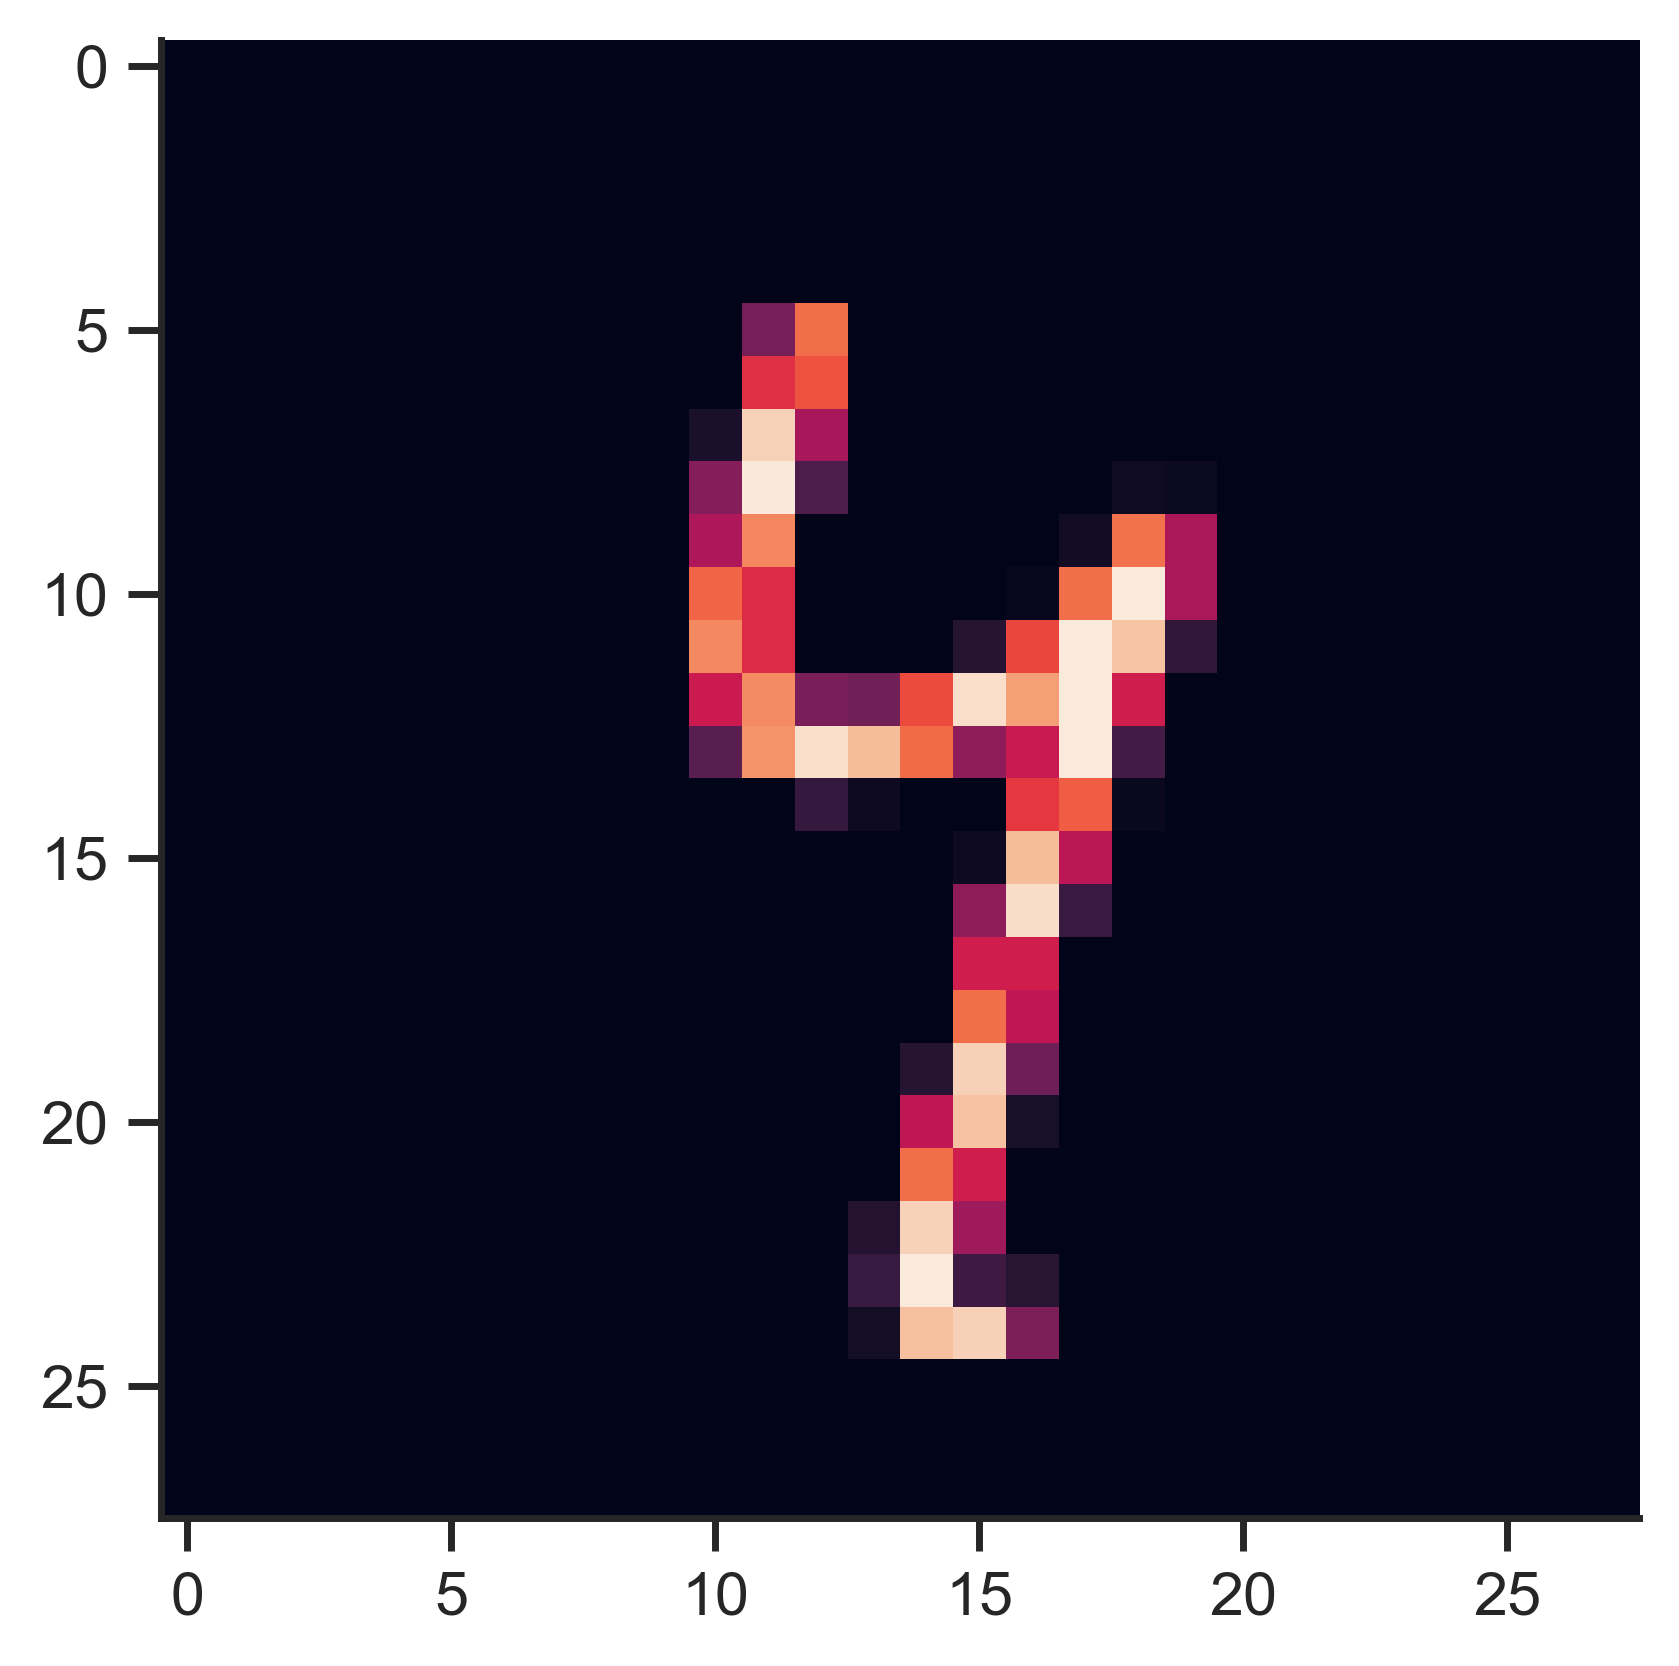

In [36]:
plt.imshow(img_test[i].reshape(28,28))

In [37]:
nearest_six = clf.kneighbors(
    img_test[i].reshape(1,-1),
    n_neighbors=6,
    return_distance=False
)

nearest_six

array([[ 6960, 11993, 25343, 27459, 41547, 29300]], dtype=int64)

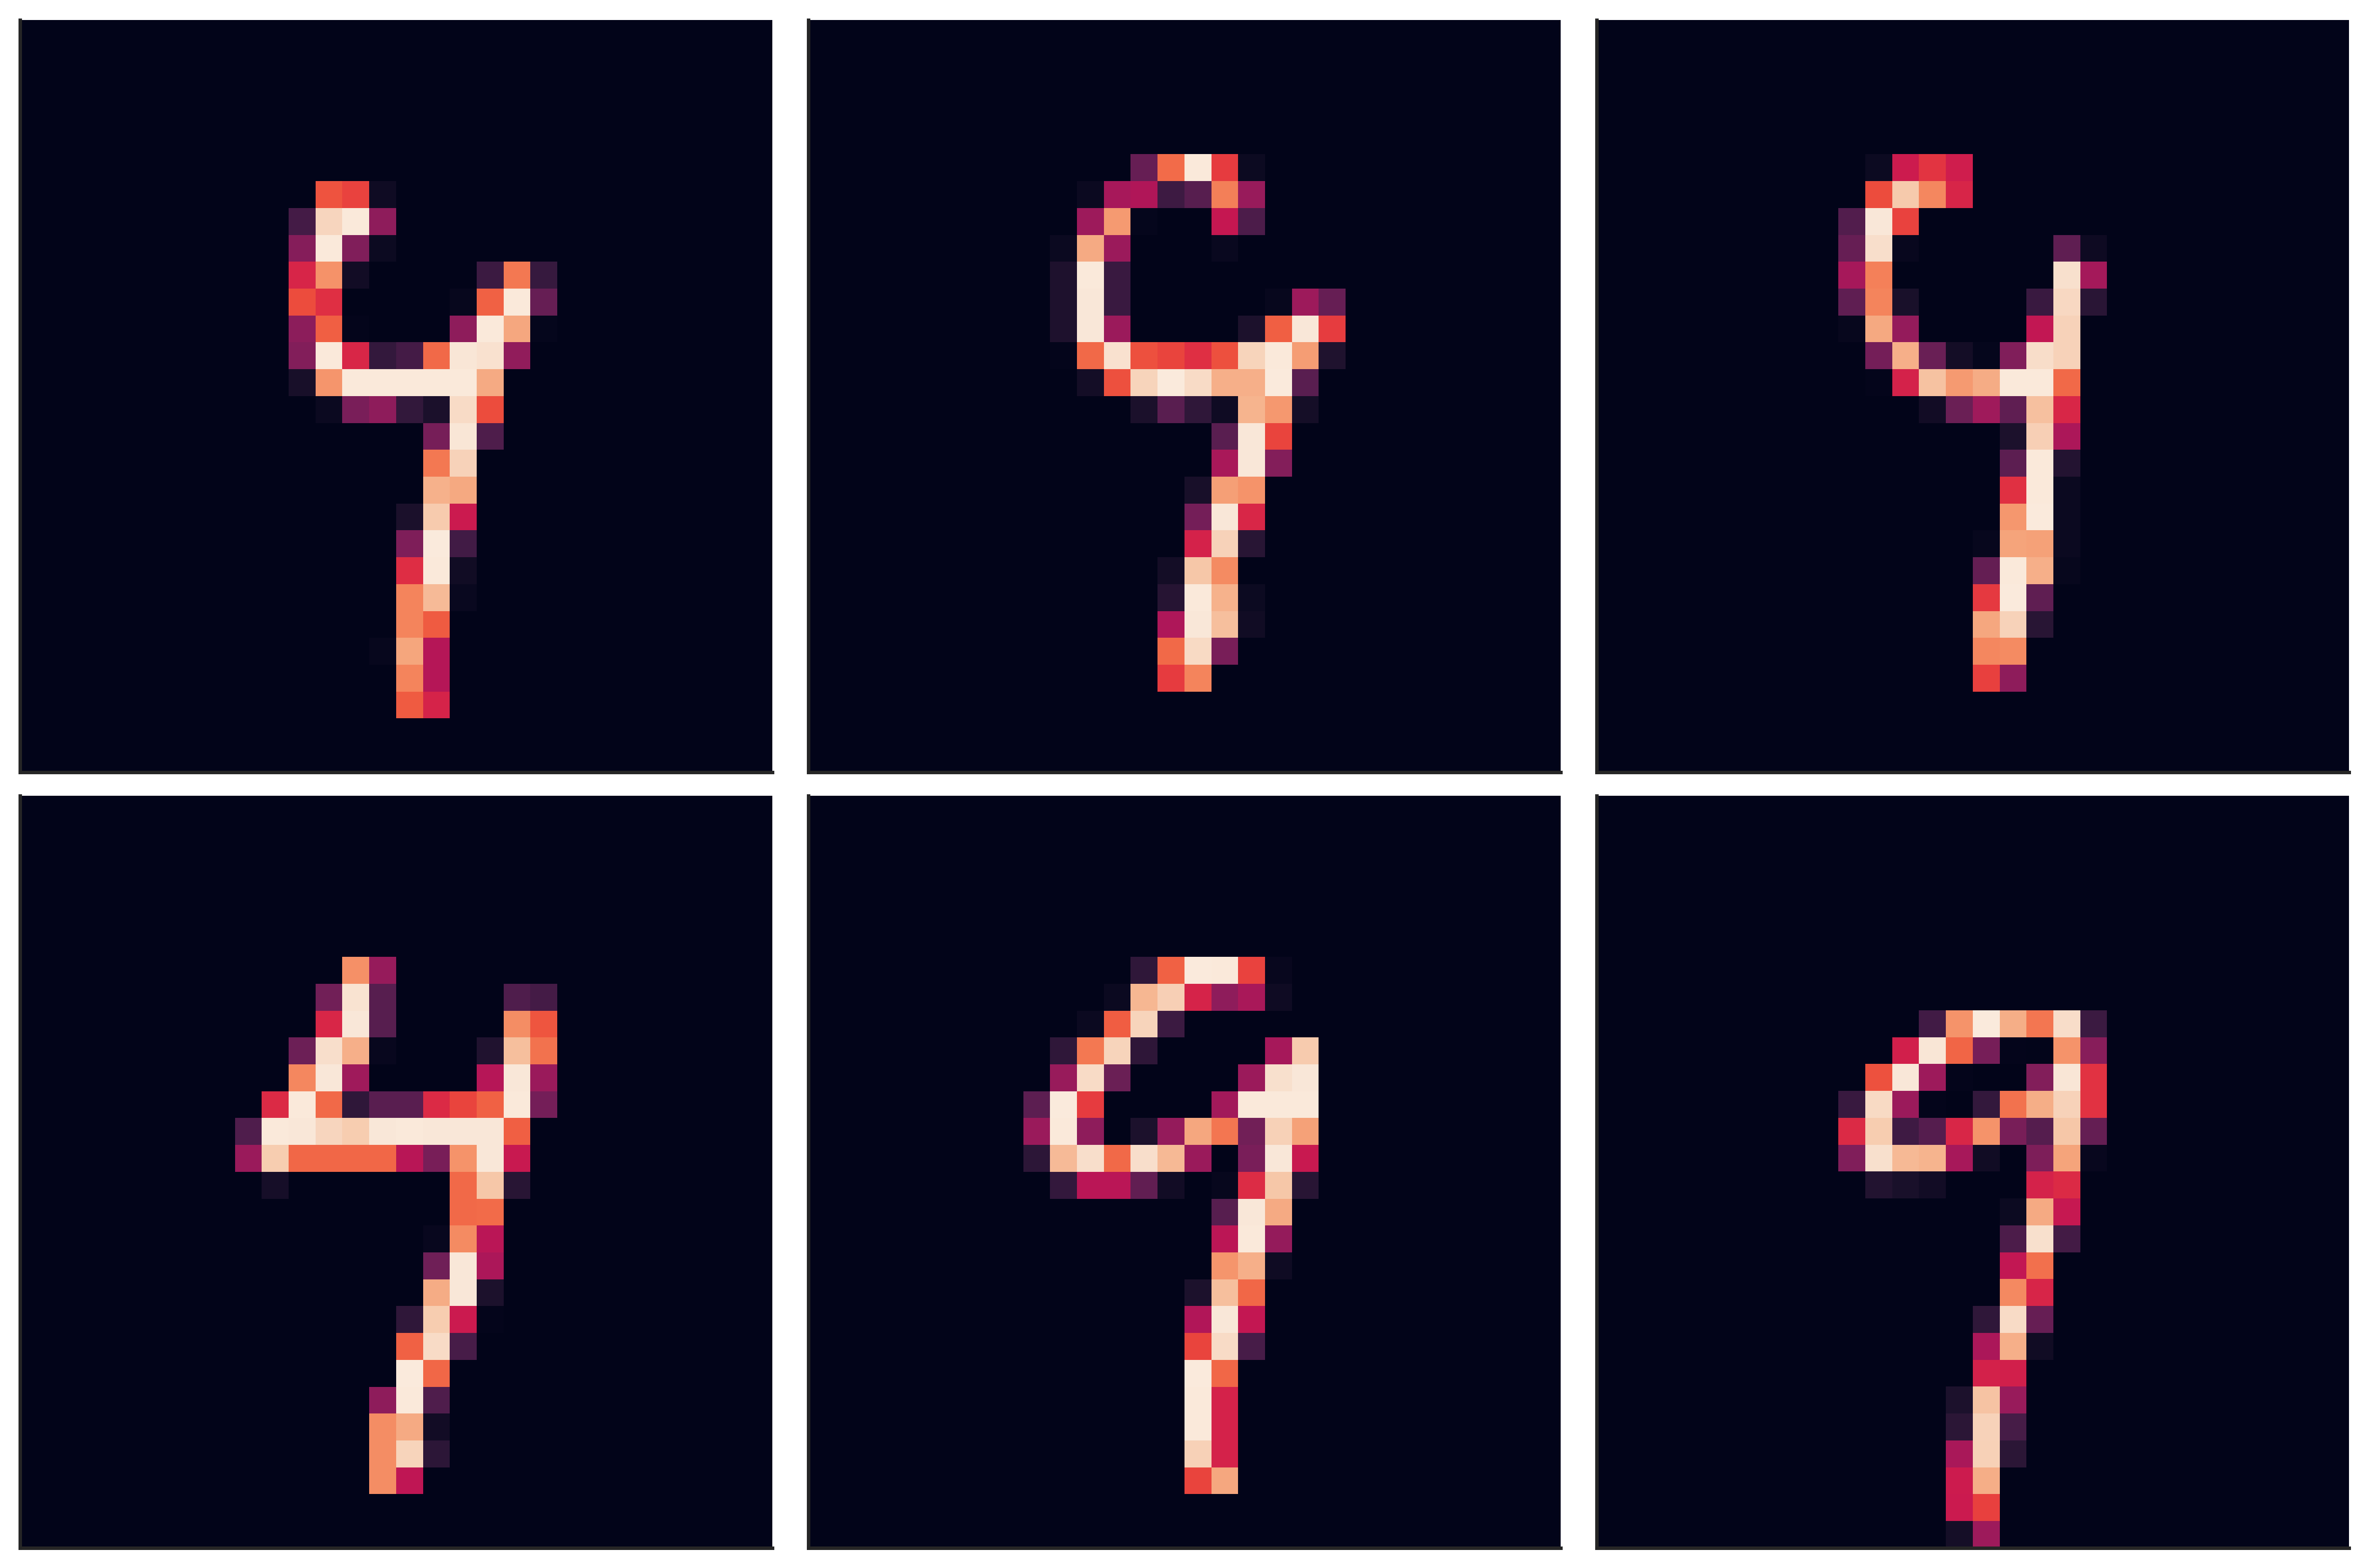

In [38]:
axs = plt.subplots(2, 3, figsize=(12,8))[1]
it = axs.flat

for index in nearest_six.squeeze():
    ax = next(it)
    ax.imshow(img_train[index].reshape(28,28))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()

_Почему они были классифицированы неправильно?_

Из-за очень схожего написания разных цифр. Обратите внимание на первое и третье изображение в первом ряду: цифры очень похожи, хотя имеют метки разных классов, первая - четверка, вторая - девятка.

In [39]:
lab_train[nearest_six]

array([[4, 9, 9, 4, 9, 9]], dtype=uint8)

***